In [3]:
import torch

In [47]:
import pymc3 as pm
import theano
import theano.tensor as tt

import pandas as pd
import numpy as np
from datetime import datetime, timedelta, date

import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('ggplot')

In [48]:
df = pd.read_csv('weekly_dmd_new.csv')
df['date'] = pd.to_datetime(df.date).apply(lambda x: x.date())
df = df.set_index(df.date)
df.index.rename('date_idx', inplace=True)
df.head(2)

,zone_id,date,total_demand_new,total_demand_new_lag1,total_demand_new_lag2,total_demand_new_lag3,total_demand_new_lag-1,total_demand_new_lag-2,total_demand_new_lag-3,smoothed_total_demand,year,total_demand_new_lag4,t4w_total_demand,month,week,day,t4w_total_demand_lag2,szn_factor
date_idx,,,,,,,,,,,,,,,,,,
2017-06-26,1,2017-06-26,1860.400531,NaN,NaN,NaN,2070.432348,2122.029861,1997.66904,NaN,2017,NaN,NaN,6,26,26,NaN,NaN
2017-06-26,582,2017-06-26,0.000000,NaN,NaN,NaN,0.000000,0.000000,0.00000,NaN,2017,NaN,NaN,6,26,26,NaN,NaN


In [674]:
covid_start_idx = date(2020,2,17)

df_prep = df.loc[(df.date < covid_start_idx)
                | (df.date >= covid_start_idx + timedelta(weeks=52))].sort_values('date')

# df_prep = df_prep.loc[df_prep.zone_id.isin([1,973,18,27,861,785,942])]
# df_prep = df_prep.loc[df_prep.zone_id.isin([1])]
df_prep['y_obs'] = df_prep.total_demand_new
# df_prep['y_obs'] = df_prep.smoothed_total_demand
df_prep['covid_start_m1'] = df_prep.date.apply(lambda x: 1.0 if x == covid_start_idx - timedelta(weeks=1) else 0)

min_date = df_prep.date.min()
df_prep['t'] = df_prep.date.apply(lambda x: (x - min_date).days / 7)

In [675]:
zone_id_ohe = pd.get_dummies(df_prep.zone_id, prefix='zone_dummy')
df_prep = pd.concat([df_prep, zone_id_ohe], axis=1)

In [676]:
df_prep.shape

(76000, 496)

In [677]:
first_ts = df_prep.loc[df_prep.y_obs > 0].groupby('zone_id').t.min().reset_index(name='first_t')
first_ts.head(2)

,zone_id,first_t
0,1,0.0
1,13,0.0


/Users/sorenzeliger/.pyenv/versions/3.8.6/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='first_t', ylabel='Density'>

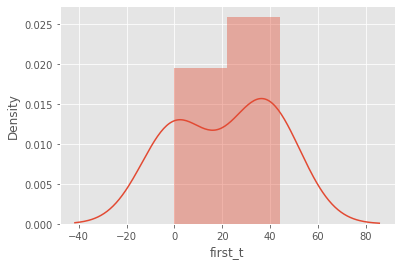

In [175]:
sns.distplot(first_ts.first_t)

In [678]:
tt = df_prep[[x for x in list(df_prep) if 'zone_dummy' in x] + ['zone_id']].drop_duplicates()
x = torch.from_numpy(np.array(tt))

In [679]:
x.shape

torch.Size([475, 476])

In [80]:
data_sample = task.supply_estimator.df_clean.loc[task.supply_estimator.df_clean.zone_id.isin([1,973,18,27,861,785,942])].reset_index(drop=True)
data_sample.shape

(2386, 74)

In [206]:
zone_id_ohe = pd.get_dummies(data_sample.zone_id, prefix='zone_dummy')
data_sample = pd.concat([data_sample, zone_id_ohe], axis=1)

In [207]:
data_sample['intercept'] = 1

In [208]:
data_sample.shape

(233268, 759)

In [84]:
data_sample[[x for x in list(data_sample) if 'zone_dummy' in x]].head(2)

,zone_dummy_1,zone_dummy_18,zone_dummy_27,zone_dummy_785,zone_dummy_861,zone_dummy_942,zone_dummy_973
0,1,0,0,0,0,0,0
1,1,0,0,0,0,0,0


In [209]:
x = torch.from_numpy(np.array(data_sample[[x for x in list(data_sample) if 'zone_dummy' in x]]))

y = torch.from_numpy(np.array(data_sample.logit_capacity_avail))

In [210]:
feats = torch.from_numpy(np.array(data_sample[['ratio', 'intercept']]))
feats

tensor([[0.3341, 1.0000],
        [0.6107, 1.0000],
        [0.4055, 1.0000],
        ...,
        [0.6964, 1.0000],
        [1.2947, 1.0000],
        [0.4536, 1.0000]], dtype=torch.float64)

In [ ]:
# for time-varying parameters:
    # 1) can model W_t as a random walk from W_t-1
        # then assume gaussian error on logit-scale
        # so data likelihood is Pr(weights)*Pr(data|weights), which we can compute since both are gaussian
        # Pr(weights) = Pr(weights_at_t3|weights_at_t2)*Pr(weights_at_t2|weights_at_t1)*Pr(weights_at_t1)
        
        # would this require custom layer? where we do sth like:
            # torch.nn.Parameter_at_time_t ~ N(torch.nn.Parameter_at_time_t-1, sigma_parameter)
            # below when we do a sequence of linear layers, each linear layer has its weights applied to whole dataset
            # what we would want is for each linear layer to have n_weights = T
            # and then when we apply the layer, we just have to mult weights_at_t with data_at_t
    # 2) can have the final model params be a function of RNN
        # zone embedding would happen within this model
    
# is (2) basically just a more general approach whereas (1) is assuming more about the nature of the function over time

In [ ]:
# y_pred
# [] first, implement in simplest way, ie as loop
# [] then, can see if torch has functions to speed it up. can look at how they implement RNNs maybe



In [53]:
szn_len = 52
n_zones = 5

# initial_szns, initial trend, initial slope, smoothing params, covid_level_change, covid_level_change2
# n_params = szn_len + 2 + 3 + 2

n_params = 2 + 3 + 2

# a = torch.randn(n_zones, n_params)
b = torch.randn(n_zones, n_params)

# c = torch.sum(a * b, dim=-1)

# print(c.shape)

In [55]:
szns = torch.Tensor(np.random.normal(1.0, 0.2, (n_zones, 52)))

In [56]:
a = torch.cat((szns, b), 1)
a.shape

torch.Size([5, 59])

In [75]:
z_idx_to_z_id_map = {0: 1}
z_idx_to_z_id_map

{0: 1}

In [76]:
z_idx = 0

z_params = a[z_idx]
first_t = first_ts.loc[first_ts.zone_id == z_idx_to_z_id_map[z_idx]].first_t.item()

In [165]:
z_idx = 0

z_id = z_idx_to_z_id_map[z_idx]
z_params = a[z_idx]
first_t = int(first_ts.loc[first_ts.zone_id == z_id].first_t.item())
initial_szns = z_params[:52]
initial_szns_ordered = torch.cat((initial_szns[first_t%52:], initial_szns[:first_t%52]))
initial_trend, initial_level = z_params[52:54]
smoothing_szn, smoothing_level, smoothing_trend = z_params[54:57]
covid_level_change, covid_level_change2 = z_params[57:59]

zdf = df_prep.loc[df_prep.zone_id == z_id]
covid_start_indicator = torch.Tensor(zdf['covid_start_m1'])
ys = torch.Tensor(zdf['y_obs'])

# in_sample_preds = calc_in_sample_preds(ys, initial_szns_ordered, initial_trend, initial_level, smoothing_szn, smoothing_level, smoothing_trend, covid_level_change, covid_level_change2, covid_start_indicator)

In [166]:
smoothing_level = torch.Tensor([0.8])[0]
smoothing_trend = torch.Tensor([0.2])[0]
smoothing_szn = torch.Tensor([0.15])[0]

In [167]:
covid_level_change = torch.Tensor([2000])[0]
covid_level_change2 = torch.Tensor([2200])[0]
initial_level = torch.Tensor([2000])[0]
initial_trend = torch.Tensor([0])[0]

In [168]:
# can vectorize this to loop once and do the computation for all zones

levels = initial_level.reshape(1)
trends = initial_trend.reshape(1)
# on each iter, take the next element in initial_szns_ordered
# start w/ element 0
# keep tacking on updated_szn

for i in range(len(ys)):
    szn_m52 = initial_szns_ordered[i]
    
    updated_szn = smoothing_szn * ys[i] / (levels[i] + trends[i]) + (1 - smoothing_szn) * szn_m52

    next_level = smoothing_level * (ys[i]/szn_m52) + (1 - smoothing_level)*(levels[i] + trends[i]) + covid_start_indicator[i]*covid_level_change

    next_trend = smoothing_trend * (next_level - levels[i]) + (1 - smoothing_trend)*trends[i] - covid_start_indicator[i]*smoothing_trend*covid_level_change2

    levels = torch.cat((levels, next_level.reshape(1)))
    trends = torch.cat((trends, next_trend.reshape(1)))
    initial_szns_ordered = torch.cat((initial_szns_ordered, updated_szn.reshape(1)))

y_hats = (levels[:-1] + trends[:-1]) * initial_szns_ordered[:-52]

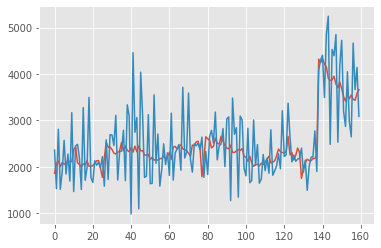

In [169]:
plt.plot(ys)
plt.plot(y_hats)

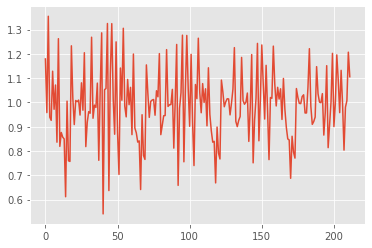

In [170]:
plt.plot(initial_szns_ordered)

In [105]:
levels

tensor([0.0683])

In [106]:
next_level

tensor(-2499.7415)

In [280]:
def calc_in_sample_preds(ys, initial_szns, initial_trend, initial_level, smoothing_szn, smoothing_level, smoothing_trend, covid_level_change, covid_level_change2, covid_start_indicator):
    
    levels = initial_level.reshape(1)
    trends = initial_trend.reshape(1)
    # on each iter, take the next element in initial_szns_ordered
    # start w/ element 0
    # keep tacking on updated_szn

    for i in range(len(ys)):
        szn_m52 = initial_szns[i]

        updated_szn = smoothing_szn * ys[i] / (levels[i] + trends[i]) + (1 - smoothing_szn) * szn_m52

        next_level = smoothing_level * (ys[i]/szn_m52) + (1 - smoothing_level)*(levels[i] + trends[i]) + covid_start_indicator[i]*covid_level_change

        next_trend = smoothing_trend * (next_level - levels[i]) + (1 - smoothing_trend)*trends[i] - covid_start_indicator[i]*smoothing_trend*covid_level_change2

        levels = torch.cat((levels, next_level.reshape(1)))
        trends = torch.cat((trends, next_trend.reshape(1)))
        initial_szns = torch.cat((initial_szns, updated_szn.reshape(1)))

    y_hats = (levels[:-1] + trends[:-1]) * initial_szns[:-52]
    
    return y_hats

In [ ]:
# maybe having trouble learning because we need to help it know the possible range of values for various params?
    # possible to pass a guide?
# bug?
# is the backprop not picking up on the looping ish we're doing in order to calc y_hats?

In [680]:
#### Define model

n_zones = x.shape[0]
zone_embedding_dim = 3
# initial_szns, initial trend, initial slope, smoothing params, covid_level_change, covid_level_change2
n_params = szn_len + 2 + 3 + 2
# n_params = szn_len + 3
# n_params_of_final_function = n_params - szn_len
n_params_of_final_function = n_params

zone_specific_params = 4 # initial level, initial trend, covid_level_change, covid_level_change2

model = torch.nn.Sequential(
#     torch.nn.functional.relu(torch.nn.Linear(n_zones, zone_embedding_dim)),
    torch.nn.Linear(n_zones, 30),
    torch.nn.ReLU(),
    torch.nn.Linear(30, 15),
    torch.nn.ReLU(),
    torch.nn.Linear(15, zone_embedding_dim),
    torch.nn.ReLU(),
    torch.nn.Linear(zone_embedding_dim, n_params_of_final_function),
#     torch.nn.ReLU()
    # for this layer, want a linear combo of the final params and sd_ratio + 1 (for int)
    # actuall nothing learnable anymore, just want the params
    
#     torch.nn.Linear(n_params_of_final_function, 1)
#     torch.nn.Flatten(0, 1)
    
#     out = self.fc1(x)
#     out = F.relu(self.fc1(x))
)

# model = torch.nn.Sequential(
# #     torch.nn.functional.relu(torch.nn.Linear(n_zones, zone_embedding_dim)),
#     torch.nn.Linear(n_zones, zone_embedding_dim),
#     torch.nn.ReLU(),
#     torch.nn.Linear(zone_embedding_dim, n_params_of_final_function),
# #     torch.nn.ReLU()
#     # for this layer, want a linear combo of the final params and sd_ratio + 1 (for int)
#     # actuall nothing learnable anymore, just want the params
    
# #     torch.nn.Linear(n_params_of_final_function, 1)
# #     torch.nn.Flatten(0, 1)
    
# #     out = self.fc1(x)
# #     out = F.relu(self.fc1(x))
# )

# model = torch.nn.Sequential(
#     torch.nn.Linear(n_zones, zone_embedding_dim),
#     torch.nn.Linear(zone_embedding_dim, n_params_of_final_function),
#     # for this layer, want a linear combo of the final params and sd_ratio + 1 (for int)
#     # actuall nothing learnable anymore, just want the params
    
# #     torch.nn.Linear(n_params_of_final_function, 1)
# #     torch.nn.Flatten(0, 1)
    
# )

loss_fn = torch.nn.MSELoss(reduction='sum')

In [628]:
for param in model.parameters():
    print(type(param), param.size())

<class 'torch.nn.parameter.Parameter'> torch.Size([3, 7])
<class 'torch.nn.parameter.Parameter'> torch.Size([3])
<class 'torch.nn.parameter.Parameter'> torch.Size([59, 3])
<class 'torch.nn.parameter.Parameter'> torch.Size([59])


In [689]:
def calc_all_y_preds(params_of_final_function):
    y_hats_all = torch.Tensor()
    y_actual_all = torch.Tensor()

    for z_idx in range(params_of_final_function.shape[0]):
        z_id = int(x[:,-1][z_idx])
        z_params = params_of_final_function[z_idx]
        first_t = int(first_ts.loc[first_ts.zone_id == z_id].first_t.item())
#         initial_szns = z_params[:52]
        initial_szns = z_params[:52].clamp(0,2)
#         initial_szns = torch.Tensor([1.0 for i in range(52)])
        initial_szns_ordered = torch.cat((initial_szns[first_t%52:], initial_szns[:first_t%52]))
#         initial_trend, initial_level = z_params[52:54]
#         initial_trend, initial_level = z_params[0:2]
        initial_trend, initial_level = z_params[52:54].clamp(0,10000)
#         smoothing_szn, smoothing_level, smoothing_trend = z_params[54:57]
#         smoothing_szn, smoothing_level, smoothing_trend = torch.sigmoid(z_params[2:5])
        smoothing_szn, smoothing_level, smoothing_trend = torch.sigmoid(z_params[54:57])
#         covid_level_change, covid_level_change2 = z_params[57:59]
#         covid_level_change, covid_level_change2 = z_params[5:7]
        covid_level_change, covid_level_change2 = z_params[57:59].clamp(0,10000)

        zdf = df_prep.loc[df_prep.zone_id == z_id]
        covid_start_indicator = torch.Tensor(zdf['covid_start_m1'])
        ys = torch.Tensor(zdf['y_obs'])

        y_hats = calc_in_sample_preds(ys, initial_szns_ordered, initial_trend, initial_level, smoothing_szn, smoothing_level, smoothing_trend, covid_level_change, covid_level_change2, covid_start_indicator)
        y_hats_all = torch.cat((y_hats_all, y_hats))

        y_actual_all = torch.cat((y_actual_all, ys))
    
    return y_hats_all, y_actual_all

In [682]:
list(model.parameters())

[Parameter containing:
 tensor([[-0.0344,  0.0237,  0.0408,  ...,  0.0077, -0.0089,  0.0055],
         [ 0.0404, -0.0183,  0.0247,  ..., -0.0042,  0.0197,  0.0457],
         [-0.0321, -0.0390, -0.0172,  ..., -0.0265, -0.0197, -0.0017],
         ...,
         [ 0.0295,  0.0285, -0.0315,  ..., -0.0378, -0.0049, -0.0089],
         [ 0.0423, -0.0420,  0.0019,  ...,  0.0109,  0.0446,  0.0009],
         [-0.0219,  0.0353,  0.0036,  ...,  0.0212, -0.0208, -0.0180]],
        requires_grad=True),
 Parameter containing:
 tensor([ 0.0007, -0.0344, -0.0456,  0.0332, -0.0446, -0.0418, -0.0276, -0.0322,
          0.0403, -0.0367,  0.0412,  0.0161,  0.0322,  0.0288,  0.0259,  0.0229,
          0.0349,  0.0090,  0.0107,  0.0424,  0.0018,  0.0081, -0.0100, -0.0178,
          0.0396,  0.0054, -0.0435, -0.0014, -0.0448, -0.0248],
        requires_grad=True),
 Parameter containing:
 tensor([[-0.0443, -0.1107,  0.0364,  0.0997,  0.0558, -0.0295, -0.0298, -0.0791,
          -0.1677,  0.1585, -0.1677, -0.004

In [585]:
list(model.parameters())

[Parameter containing:
 tensor([[ 0.1392, -0.2766,  0.2069, -0.1406,  0.1094, -0.0973, -0.1106],
         [ 0.5318,  0.1073,  0.0500,  0.3355, -0.1647,  0.0631,  0.0903],
         [ 0.3746, -0.1449, -0.0401,  0.3286,  0.0313, -0.2080, -0.2533]],
        requires_grad=True),
 Parameter containing:
 tensor([ 0.1145, -0.2515,  0.2727], requires_grad=True),
 Parameter containing:
 tensor([[ 0.3279, -0.1154, -0.2846],
         [-0.4569,  0.2321, -0.3028],
         [-0.2861, -0.1056, -0.4061],
         [-0.2959,  0.0600, -0.5711],
         [ 0.0545, -0.4622,  0.1466],
         [ 0.1286, -0.5982,  0.2441],
         [ 0.5053, -0.2722,  0.2414],
         [ 0.0190, -0.5004, -0.1089],
         [ 0.3643,  0.4100, -0.1055],
         [-0.1556, -0.0504,  0.4919],
         [-0.1743, -0.2128, -0.1282],
         [-0.3455,  0.2553,  0.4460],
         [-0.1034,  0.5863,  0.1615],
         [ 0.2248,  0.4451, -0.4558],
         [-0.3930,  0.6534,  0.4645],
         [ 0.5054,  0.4711, -0.1160],
         [-0.

In [592]:
list(model.parameters())

[Parameter containing:
 tensor([[-0.4689, -0.2766,  0.7234, -0.1406,  0.1094, -0.0973, -0.1106],
         [-0.0584,  0.1073,  0.0500,  0.3355, -0.1647,  0.0631,  0.0903],
         [ 1.4204, -0.1449,  0.4192,  0.3286,  0.0313, -0.2080, -0.2533]],
        requires_grad=True),
 Parameter containing:
 tensor([ 0.1145, -0.2515,  0.2727], requires_grad=True),
 Parameter containing:
 tensor([[ 3.2791e-01, -1.1537e-01, -2.8462e-01],
         [-4.5694e-01,  2.3213e-01, -3.0280e-01],
         [-2.8606e-01, -1.0563e-01, -4.0614e-01],
         [-2.9593e-01,  6.0033e-02, -5.7106e-01],
         [ 5.4521e-02, -4.6224e-01,  1.4659e-01],
         [ 1.2863e-01, -5.9817e-01,  2.4414e-01],
         [ 5.0525e-01, -2.7218e-01,  2.4136e-01],
         [ 1.8992e-02, -5.0045e-01, -1.0891e-01],
         [ 3.6429e-01,  4.1004e-01, -1.0554e-01],
         [-1.5555e-01, -5.0401e-02,  4.9188e-01],
         [-1.7425e-01, -2.1278e-01, -1.2817e-01],
         [-3.4552e-01,  2.5535e-01,  4.4596e-01],
         [-1.0338e-01

In [669]:
list(model.modules())

[Sequential(
   (0): Linear(in_features=7, out_features=10, bias=True)
   (1): ReLU()
   (2): Linear(in_features=10, out_features=3, bias=True)
   (3): ReLU()
   (4): Linear(in_features=3, out_features=59, bias=True)
 ),
 Linear(in_features=7, out_features=10, bias=True),
 ReLU(),
 Linear(in_features=10, out_features=3, bias=True),
 ReLU(),
 Linear(in_features=3, out_features=59, bias=True)]

In [666]:
list(model.modules())[1].weight

Parameter containing:
tensor([[-0.0070, -0.8099, -0.2745, -0.2021,  0.3375, -0.2009, -0.0156],
        [    nan,     nan,     nan,     nan,     nan,     nan,     nan],
        [    nan,     nan,     nan,     nan,     nan,     nan,     nan],
        [-0.2084, -0.3015, -0.0520,  0.0268,  0.2080,  0.2091, -0.1502],
        [    nan,     nan,     nan,     nan,     nan,     nan,     nan],
        [    nan,     nan,     nan,     nan,     nan,     nan,     nan],
        [-0.1468, -0.2658,  0.0657,  0.0710,  0.1403, -0.3412, -0.0150],
        [-0.3352, -0.3212,  1.0485, -0.2951, -0.2675, -0.2603, -0.3378],
        [ 0.2356, -0.1229,  0.1629, -0.1219, -0.0806,  0.2263, -0.3376],
        [    nan,     nan,     nan,     nan,     nan,     nan,     nan]],
       requires_grad=True)

In [667]:
list(model.modules())[1].weight.grad

tensor([[ 0.0000e+00,  5.8364e+13,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [        nan,         nan,         nan,         nan,         nan,
                 nan,         nan],
        [        nan,         nan,         nan,         nan,         nan,
                 nan,         nan],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [        nan,         nan,         nan,         nan,         nan,
                 nan,         nan],
        [        nan,         nan,         nan,         nan,         nan,
                 nan,         nan],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00, -1.5441e+16,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 

In [645]:
list(model.modules())[1].weight.grad

tensor([[        nan,         nan,         nan,         nan,         nan,
                 nan,         nan],
        [ 1.4101e+16,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00, -3.8513e+16,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00]])

In [668]:
list(model.modules())[3].weight

Parameter containing:
tensor([[    nan,     nan,     nan,     nan,     nan,     nan,     nan,     nan,
             nan,     nan],
        [ 0.1064, -0.0589, -0.1258,  0.1533,  0.2667, -0.0243,  0.0701, -0.2517,
         -0.2483,  0.0025],
        [    nan,     nan,     nan,     nan,     nan,     nan,     nan,     nan,
             nan,     nan]], requires_grad=True)

In [670]:
list(model.modules())[3].weight.grad

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]])

In [671]:
list(model.modules())[5].weight

Parameter containing:
tensor([[    nan,     nan,     nan],
        [    nan,     nan,     nan],
        [    nan,     nan,     nan],
        [    nan,     nan,     nan],
        [    nan,     nan,     nan],
        [    nan,     nan,     nan],
        [    nan,     nan,     nan],
        [    nan,     nan,     nan],
        [    nan,     nan,     nan],
        [    nan,     nan,     nan],
        [    nan,     nan,     nan],
        [    nan,     nan,     nan],
        [    nan,     nan,     nan],
        [    nan,     nan,     nan],
        [    nan,     nan,     nan],
        [    nan,     nan,     nan],
        [    nan,     nan,     nan],
        [    nan,     nan,     nan],
        [    nan,     nan,     nan],
        [    nan,     nan,     nan],
        [    nan,     nan,     nan],
        [    nan,     nan,     nan],
        [    nan,     nan,     nan],
        [    nan,     nan,     nan],
        [    nan,     nan,     nan],
        [    nan,     nan,     nan],
        [    nan

In [672]:
list(model.modules())[5].weight.grad

tensor([[        nan,         nan,         nan],
        [        nan,         nan,         nan],
        [        nan,         nan,         nan],
        [        nan,         nan,         nan],
        [        nan,         nan,         nan],
        [        nan,         nan,         nan],
        [        nan,         nan,         nan],
        [        nan,         nan,         nan],
        [        nan,         nan,         nan],
        [        nan,         nan,         nan],
        [        nan,         nan,         nan],
        [        nan,         nan,         nan],
        [        nan,         nan,         nan],
        [        nan,         nan,         nan],
        [        nan,         nan,         nan],
        [        nan,         nan,         nan],
        [        nan,         nan,         nan],
        [        nan,         nan,         nan],
        [        nan,         nan,         nan],
        [        nan,         nan,         nan],
        [        nan

In [306]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

0.weight tensor([[nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan]])
0.bias tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])
1.weight tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, n

In [690]:
learning_rate = 1e-3
# learning_rate = 1e-1
# learning_rate = 1
# optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [691]:
params_of_final_function = model(x[:,:-1].float())

params_of_final_function.shape

y_hats_all, y_actual_all = calc_all_y_preds(params_of_final_function)

In [685]:
params_of_final_function.shape

torch.Size([475, 59])

In [686]:
y_hats_all

tensor([ 1.8672e-01, -2.0950e+02,  2.7925e+03,  ..., -2.2290e+03,
         6.5073e+01, -5.5150e+03], grad_fn=<CatBackward>)

In [647]:
y_hats_all

tensor([nan, nan, nan,  ..., nan, nan, nan], grad_fn=<CatBackward>)

In [687]:
y_actual_all

tensor([1860.4005, 2070.4324, 2122.0298,  ...,  432.1985,  414.1424,
         403.4436])

In [692]:
loss = loss_fn(y_hats_all, y_actual_all)
loss

tensor(nan, grad_fn=<MseLossBackward>)

In [648]:
loss = loss_fn(y_hats_all, y_actual_all)
loss

tensor(nan, grad_fn=<MseLossBackward>)

In [649]:
print('%.15f' % loss.item())

nan


In [609]:
print('%.15f' % loss.item())

49924008430930972663055646720.000000000000000


In [664]:
optimizer.zero_grad()

# Backward pass: compute gradient of the loss with respect to model
# parameters
loss.backward()

In [665]:
# Calling the step function on an Optimizer makes an update to its
# parameters
optimizer.step()

In [ ]:
# can check if we do see the weights changing on the model where we know learning happens
# wonder if calc_all_y_preds needs to be a torch fcn
    # but it does at least know that y_hats_all is a torch.Tensor
# maybe in a local min cus so non-linear and not searching effectively/need some randomness or idk

In [599]:
# learning_rate = 1e-3
# learning_rate = 1e-1
learning_rate = 1
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.Adagrad(model.parameters())
for t in range(100):
# for t in range(1000):
#     optimizer.zero_grad()
    # Forward pass: compute predicted y by passing x to the model.
    params_of_final_function = model(x[:,:-1].float())
    y_hats_all, y_actual_all = calc_all_y_preds(params_of_final_function)    
#     y_pred = torch.sum(feats * params_of_final_function, dim=1)

    # Compute and print loss.
    loss = loss_fn(y_hats_all, y_actual_all)
    if t % 2 == 0:
#     if t % 100 == 99:
        print(t)
        print('%.15f' % loss.item())

    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable
    # weights of the model). This is because by default, gradients are
    # accumulated in buffers( i.e, not overwritten) whenever .backward()
    # is called. Checkout docs of torch.autograd.backward for more details.
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()

0
49924003708564489793410433024.000000000000000
2
49924013153297455532700860416.000000000000000
4
49924013153297455532700860416.000000000000000
6
49924013153297455532700860416.000000000000000
8
49924008430930972663055646720.000000000000000
10
49924008430930972663055646720.000000000000000
12
49924008430930972663055646720.000000000000000
14
49924008430930972663055646720.000000000000000
16
49924008430930972663055646720.000000000000000
18
49924008430930972663055646720.000000000000000
20
49924008430930972663055646720.000000000000000
22
49924008430930972663055646720.000000000000000
24
49924008430930972663055646720.000000000000000
26
49924008430930972663055646720.000000000000000
28
49924008430930972663055646720.000000000000000
30
49924008430930972663055646720.000000000000000
32
49924008430930972663055646720.000000000000000
34
49924008430930972663055646720.000000000000000
36
49924008430930972663055646720.000000000000000
38
49924008430930972663055646720.000000000000000
40
4992400843093097266305

KeyboardInterrupt: 

In [339]:
loss

tensor(1.1438e+25, grad_fn=<MseLossBackward>)

In [245]:
model.parameters()

<generator object Module.parameters at 0x151603510>

In [ ]:
# need to handle:
    # [/] diff starting dates
    # [/] covid_jump
    # [] align things correctly -- ie obs_lag-1 with training
    # [] accessed everything by z_id in the above loop, but may need to tweak that

In [ ]:
# given zone_params, compute preds
# zone_params: tensor of shape (n_zones, n_params)



In [213]:
n_zones = x.shape[1]
zone_embedding_dim = 3
n_params_of_final_function = 2 # ie intercept + slope = 2 params

model = torch.nn.Sequential(
    torch.nn.Linear(n_zones, zone_embedding_dim),
    torch.nn.Linear(zone_embedding_dim, n_params_of_final_function),
    # for this layer, want a linear combo of the final params and sd_ratio + 1 (for int)
    # actuall nothing learnable anymore, just want the params
    
#     torch.nn.Linear(n_params_of_final_function, 1)
#     torch.nn.Flatten(0, 1)
)
loss_fn = torch.nn.MSELoss(reduction='sum')

In [237]:
learning_rate = 1e-3
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
for t in range(1000):
    # Forward pass: compute predicted y by passing x to the model.
    params_of_final_function = model(x.float())
    y_pred = torch.sum(feats * params_of_final_function, dim=1)

    # Compute and print loss.
    loss = loss_fn(y_pred, y)
    if t % 100 == 99:
        print(t, loss.item())

    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable
    # weights of the model). This is because by default, gradients are
    # accumulated in buffers( i.e, not overwritten) whenever .backward()
    # is called. Checkout docs of torch.autograd.backward for more details.
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()

99 652433.0391673663
199 639534.3018971084
299 628686.2383346936
399 619886.8578079572
499 613219.6458116273
599 608500.0720278921
699 605339.5208217041
799 603298.6873747088
899 602013.3992106845
999 601206.7736847717


In [ ]:
#### SD Ratio stuff below

In [80]:
data_sample = task.supply_estimator.df_clean.loc[task.supply_estimator.df_clean.zone_id.isin([1,973,18,27,861,785,942])].reset_index(drop=True)
data_sample.shape

(2386, 74)

In [205]:
data_sample = task.supply_estimator.df_clean.reset_index(drop=True)
data_sample.shape

(233268, 74)

In [206]:
zone_id_ohe = pd.get_dummies(data_sample.zone_id, prefix='zone_dummy')
data_sample = pd.concat([data_sample, zone_id_ohe], axis=1)

In [207]:
data_sample['intercept'] = 1

In [208]:
data_sample.shape

(233268, 759)

In [84]:
data_sample[[x for x in list(data_sample) if 'zone_dummy' in x]].head(2)

,zone_dummy_1,zone_dummy_18,zone_dummy_27,zone_dummy_785,zone_dummy_861,zone_dummy_942,zone_dummy_973
0,1,0,0,0,0,0,0
1,1,0,0,0,0,0,0


In [209]:
x = torch.from_numpy(np.array(data_sample[[x for x in list(data_sample) if 'zone_dummy' in x]]))

y = torch.from_numpy(np.array(data_sample.logit_capacity_avail))

In [210]:
feats = torch.from_numpy(np.array(data_sample[['ratio', 'intercept']]))
feats

tensor([[0.3341, 1.0000],
        [0.6107, 1.0000],
        [0.4055, 1.0000],
        ...,
        [0.6964, 1.0000],
        [1.2947, 1.0000],
        [0.4536, 1.0000]], dtype=torch.float64)

In [ ]:
# for time-varying parameters:
    # 1) can model W_t as a random walk from W_t-1
        # then assume gaussian error on logit-scale
        # so data likelihood is Pr(weights)*Pr(data|weights), which we can compute since both are gaussian
        # Pr(weights) = Pr(weights_at_t3|weights_at_t2)*Pr(weights_at_t2|weights_at_t1)*Pr(weights_at_t1)
        
        # would this require custom layer? where we do sth like:
            # torch.nn.Parameter_at_time_t ~ N(torch.nn.Parameter_at_time_t-1, sigma_parameter)
            # below when we do a sequence of linear layers, each linear layer has its weights applied to whole dataset
            # what we would want is for each linear layer to have n_weights = T
            # and then when we apply the layer, we just have to mult weights_at_t with data_at_t
    # 2) can have the final model params be a function of RNN
        # zone embedding would happen within this model
    
# is (2) basically just a more general approach whereas (1) is assuming more about the nature of the function over time

In [213]:
n_zones = x.shape[1]
zone_embedding_dim = 3
n_params_of_final_function = 2 # ie intercept + slope = 2 params

model = torch.nn.Sequential(
    torch.nn.Linear(n_zones, zone_embedding_dim),
    torch.nn.Linear(zone_embedding_dim, n_params_of_final_function),
    # for this layer, want a linear combo of the final params and sd_ratio + 1 (for int)
    # actuall nothing learnable anymore, just want the params
    
#     torch.nn.Linear(n_params_of_final_function, 1)
#     torch.nn.Flatten(0, 1)
)
loss_fn = torch.nn.MSELoss(reduction='sum')

In [237]:
learning_rate = 1e-3
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
for t in range(1000):
    # Forward pass: compute predicted y by passing x to the model.
    params_of_final_function = model(x.float())
    y_pred = torch.sum(feats * params_of_final_function, dim=1)

    # Compute and print loss.
    loss = loss_fn(y_pred, y)
    if t % 100 == 99:
        print(t, loss.item())

    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable
    # weights of the model). This is because by default, gradients are
    # accumulated in buffers( i.e, not overwritten) whenever .backward()
    # is called. Checkout docs of torch.autograd.backward for more details.
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()

99 652433.0391673663
199 639534.3018971084
299 628686.2383346936
399 619886.8578079572
499 613219.6458116273
599 608500.0720278921
699 605339.5208217041
799 603298.6873747088
899 602013.3992106845
999 601206.7736847717


In [215]:
loss.item()

672552.5094239378

In [216]:
y_pred

tensor([3.1893, 4.6955, 3.5783,  ..., 2.7548, 4.6859, 1.9708],
       dtype=torch.float64, grad_fn=<SumBackward1>)

In [217]:
data_sample['new_preds'] = y_pred.tolist()

In [218]:
import oak.utils as utils

In [219]:
data_sample['new_filtered_capacity_on_preds'] = utils.sigmoid(data_sample.new_preds)

In [220]:
data_sample[['preds', 'new_preds']].sample(5)

,preds,new_preds
51017,2.453997,2.550163
51520,3.990890,4.146582
126707,4.605429,4.674178
140431,4.493937,4.712293
143655,1.257535,0.593405


In [221]:
data_sample.zone_id.unique()

array([ 347,  551,  983,  692,  818,  237,  183,  305,  575,  244,  184,
        771,  760,  182,  185,  169, 1418,  356, 1469,  758,  274,  974,
        936,  590, 1002,  365,  392,  205,  564,   79,   90,  178,  351,
        463,  581,  776,  166,  561,  583,  675,  539,  537,  195,  292,
        523,  376, 1116,  952,  469,  697,   33,  710,  819,  358,  465,
        378,  144,  437,  912,  827,  341,  103,  602,  393,  979,  223,
        127,  447, 1445, 1415,  298,  101,  179,    1, 1029,  280,  986,
        259,  806,  402,  367,  723,  721,  319,  472,  207,  755,  831,
        154,  970,  508,  694,  988,  374,  521,  176, 1506,  959,  218,
        981, 1085,  702,  714,  783,   73,  839,  571,  662,  698,  304,
         28,  972,  333, 1001,  320,  632,  861,   16,  216,  353,  104,
        272,  226,  817,  629,   27,  427, 1497,  466,  640,  528,  658,
       1711,  387,  939,  451,  246, 1120,  364,  507,  530,   76,  359,
        425,  235,  250,  206,  357,  982,  643,  5

In [234]:
z_id = 973

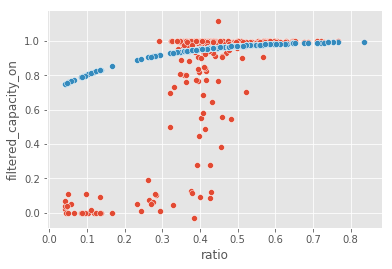

In [235]:
ax = sns.scatterplot(x='ratio', y='filtered_capacity_on', data=data_sample.loc[data_sample.zone_id == z_id])
sns.scatterplot(x='ratio', y='new_filtered_capacity_on_preds', data=data_sample.loc[data_sample.zone_id == z_id])

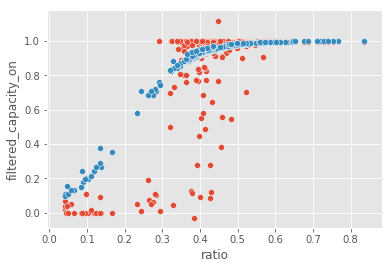

In [236]:
ax = sns.scatterplot(x='ratio', y='filtered_capacity_on', data=data_sample.loc[data_sample.zone_id == z_id])
sns.scatterplot(x='ratio', y='filtered_capacity_on_preds', data=data_sample.loc[data_sample.zone_id == z_id])

In [188]:
x

tensor([[1, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 1, 0,  ..., 0, 0, 0],
        [0, 1, 0,  ..., 0, 0, 0],
        [0, 1, 0,  ..., 0, 0, 0]], dtype=torch.uint8)

In [158]:
params_of_final_function = model(x.float())
params_of_final_function

tensor([[-0.4672, -0.1211],
        [-0.4672, -0.1211],
        [-0.4672, -0.1211],
        ...,
        [-0.3958, -0.4067],
        [-0.3958, -0.4067],
        [-0.3958, -0.4067]], grad_fn=<AddmmBackward>)

In [159]:
params_of_final_function.shape

torch.Size([2386, 2])

In [113]:
feats = torch.from_numpy(np.array(data_sample[['ratio', 'intercept']]))
feats

tensor([[0.4545, 1.0000],
        [0.3865, 1.0000],
        [0.4232, 1.0000],
        ...,
        [1.1238, 1.0000],
        [0.9846, 1.0000],
        [0.9729, 1.0000]], dtype=torch.float64)

In [125]:
feats.shape

torch.Size([2386, 2])

In [161]:
y_pred = torch.sum(feats * params_of_final_function, dim=1)